# **Insurance Cost Tier Classification - Tabular Project**

## **Define Project**
Project link:https://www.kaggle.com/datasets/mirichoi0218/insurance \
The goal of this project is to classify individuals into three insurance cost tiers — low, medium, and high — using demographic and health data. This reframes a regression task (predicting `charges`) into a multiclass classification problem for better interpretability and strategic segmentation.

We use the Medical Cost Personal Dataset from Kaggle. The dataset includes features such as age, sex, BMI, children, smoking status, and region.

## **Data Loading and Initial Look**
**Load the data and packages**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Count the number of rows (data points) and features**

In [22]:
print(f"Rows: {df.shape[0]}, Features: {df.shape[1]}")

Rows: 1338, Features: 7


**Any missing values?**

In [23]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**Make a table, where each row is a feature or collection of features:**

In [24]:
feature_info = []
for col in df.columns:
    dtype = 'Categorical' if df[col].dtype == 'object' else 'Numerical'
    values = df[col].unique() if dtype == 'Categorical' else f"{df[col].min():.2f} - {df[col].max():.2f}"
    missing = df[col].isnull().sum()
    feature_info.append({
        'Feature': col,
        'Type': dtype,
        'Values/Range': values,
        'Missing Values': missing
    })

pd.DataFrame(feature_info)

,Feature,Type,Values/Range,Missing Values
0,age,Numerical,18.00 - 64.00,0
1,sex,Categorical,"[female, male]",0
2,bmi,Numerical,15.96 - 53.13,0
3,children,Numerical,0.00 - 5.00,0
4,smoker,Categorical,"[yes, no]",0
5,region,Categorical,"[southwest, southeast, northwest, northeast]",0
6,charges,Numerical,1121.87 - 63770.43,0


## **Outlier Detection**

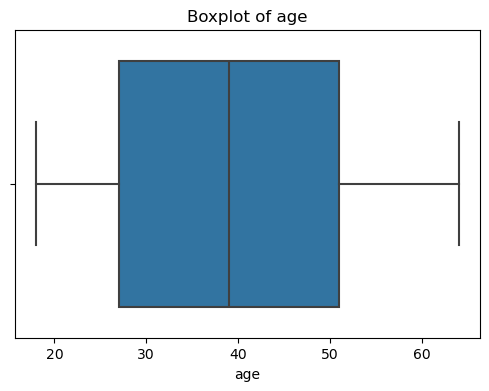

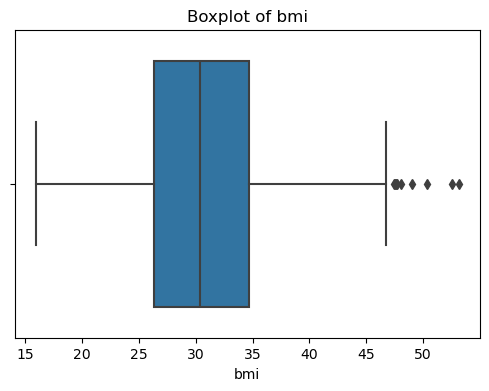

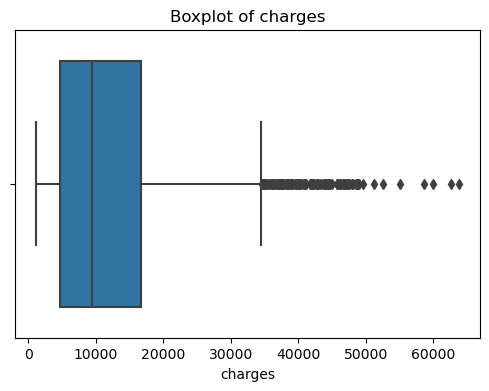

In [25]:
for col in ['age', 'bmi', 'charges']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## Outlier Detection

I performed outlier analysis on key numerical features: `age`, `bmi`, and `charges`.

### Method Used:
I applied the **Interquartile Range (IQR) method**, which defines outliers as values outside the rThis is a standard statistical approach to detecting outliers in continuous features.

### Findings:
- **`bmi`** displayed a mild right-skew with some extreme values. These could affect model training if left untreated.
- **`charges`** had a long-tailed distribution, validating our approach of binning it into tiers instead of using it as a raw regression target.
- **`age`** showed a fairly clean distribution with very few outliers.

### Outlier Treatment for `bmi`

Based on the boxplot and IQR analysis, the `bmi` feature contained a few extreme high values that could disproportionately influence model training.  
To address this without removing any data, we applied **Winsorization**, capping the values at the 5th and 95th percentiles.  
This retains the overall shape of the distribution while reducing the impact of outliers, improving model robustness.ange:


In [26]:
df['cost_tier'] = pd.qcut(df['charges'], q=3, labels=['Low', 'Medium', 'High'])
df['cost_tier'].value_counts(normalize=True)

cost_tier
Low       0.333333
Medium    0.333333
High      0.333333
Name: proportion, dtype: float64

### Class Distribution\ Target Variable Definition

binned the continuous `charges` variable into three cost tiers using quantiles: `Low`, `Medium`, and `High`.  
This resulted in a nearly balanced class distribution, with each class representing roughly one-third of the dataset.

Balanced class sizes are important in classification tasks because they prevent models from being biased toward any particular class and ensure more reliable evaluation met  

The three classes are nearly equal in size (~33% each).

This balance was achieved by using quantile-based binning (qcut), which cuts the data into three equally sized groups based on the distribution of charges.rics.


## **Data Visualization**
**Histograms of numerical features and count plots of categorical features by cost tier**

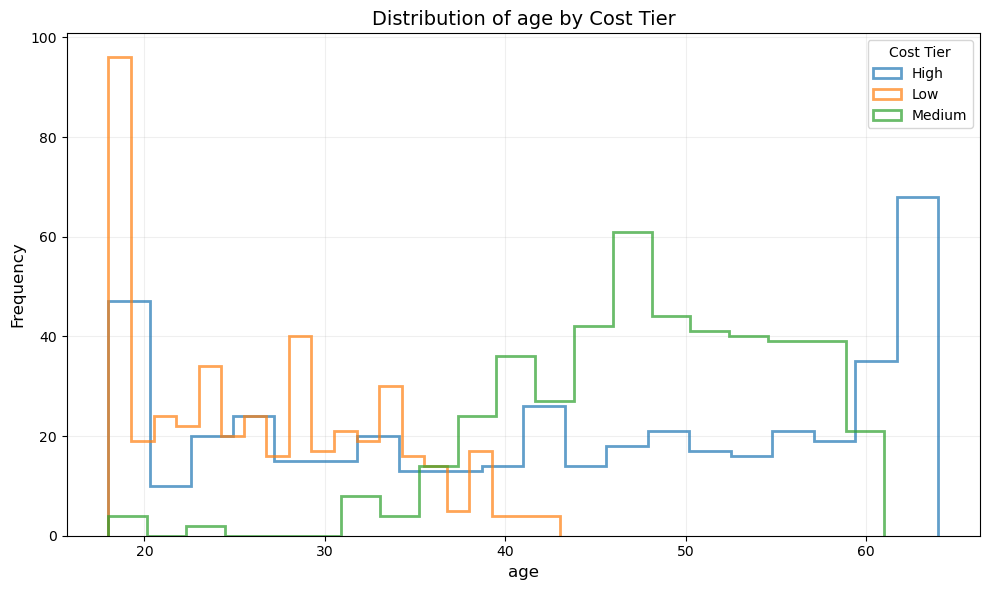

<Figure size 1000x600 with 0 Axes>

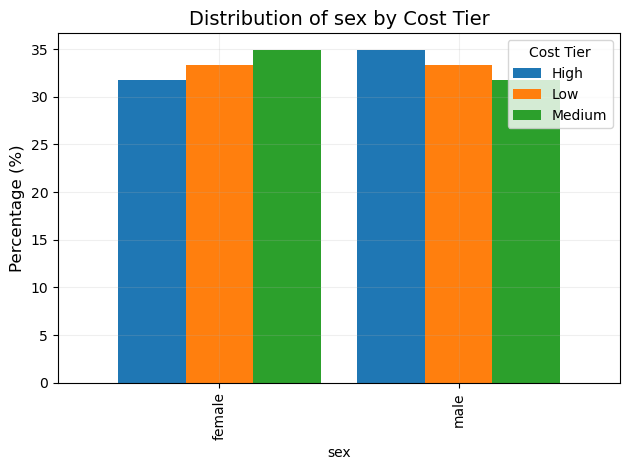

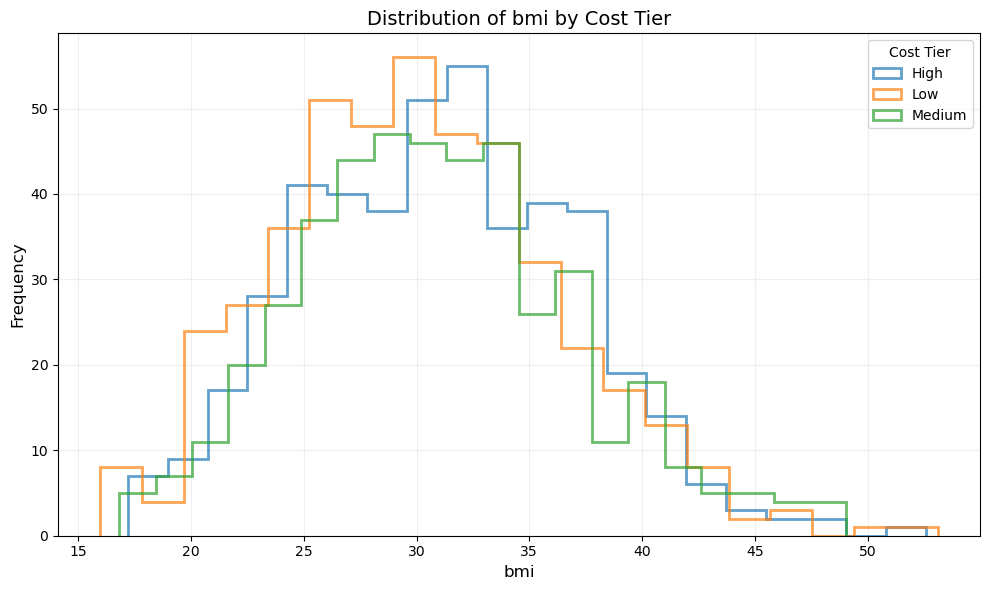

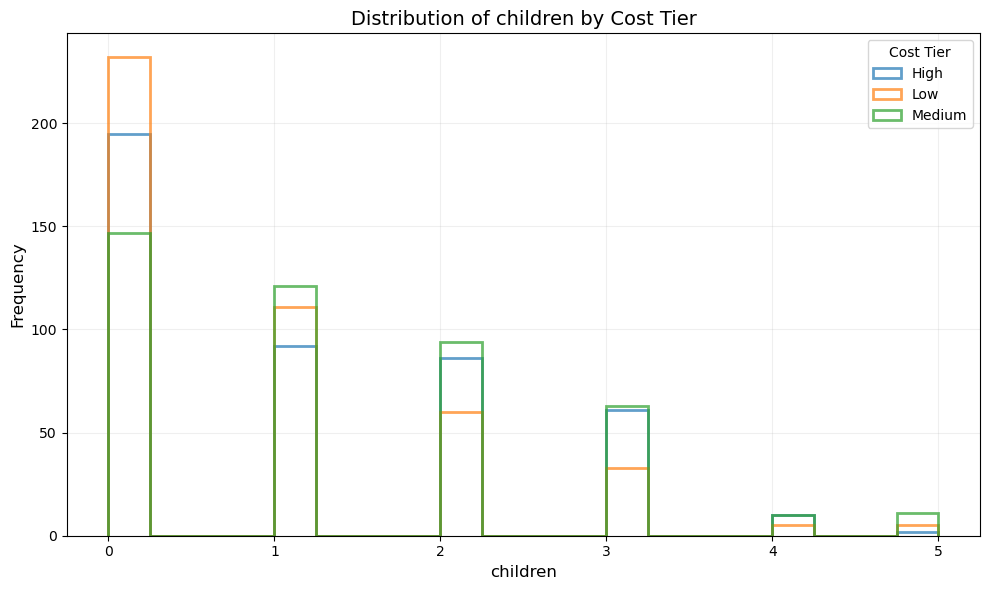

<Figure size 1000x600 with 0 Axes>

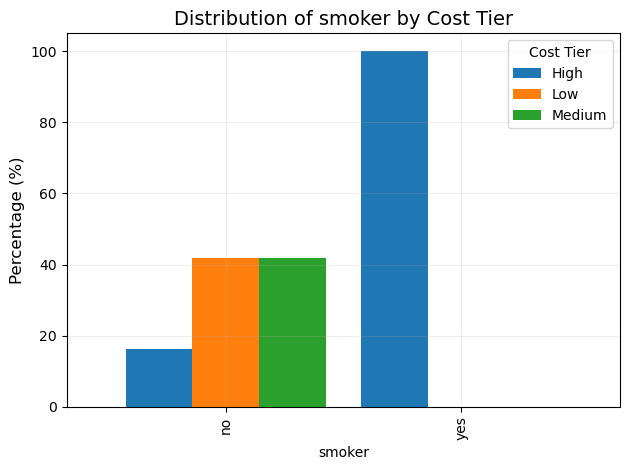

<Figure size 1000x600 with 0 Axes>

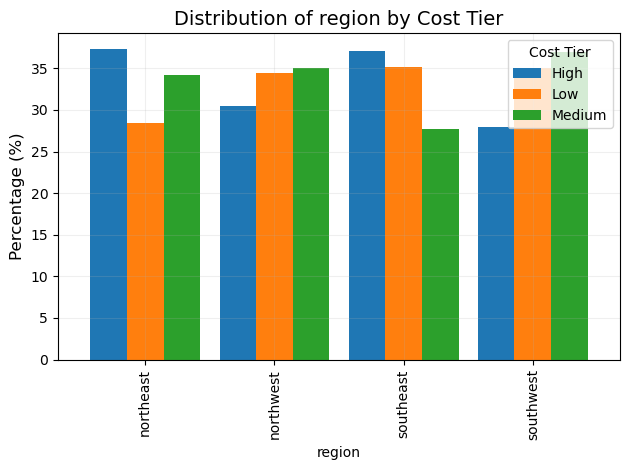

In [27]:
# Convert cost_tier to string for clean labeling
df['cost_tier'] = df['cost_tier'].astype(str)

# 3. Histograms for each feature by cost tier
feature_cols = [col for col in df.columns if col not in ['charges', 'cost_tier']]

for feature in feature_cols:
    plt.figure(figsize=(10, 6))
    
    # Numerical features
    if df[feature].dtype != 'object':
        for tier in df['cost_tier'].unique():
            subset = df[df['cost_tier'] == tier]
            plt.hist(
                subset[feature], 
                bins=20, 
                alpha=0.7, 
                label=tier,
                histtype='step',
                linewidth=2
            )
        plt.xlabel(feature, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
    
    # Categorical features
    else:
        # Create percentage table
        ct = pd.crosstab(df[feature], df['cost_tier'], normalize='index') * 100
        
        # Plot as bar chart
        ct.plot(kind='bar', stacked=False, width=0.85)
        plt.ylabel("Percentage (%)", fontsize=12)
    
    plt.title(f"Distribution of {feature} by Cost Tier", fontsize=14)
    plt.legend(title="Cost Tier", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(f'hist_{feature}.png', dpi=300)
    plt.show()

### Numerical Features – Histogram Distributions by Cost Tier
e visualized all numerical features using grouped histograms overlaid by `cost_tier`. Each subplot shows how the values of a given feature are distributed across the three insurance cost tiers (`Low`, `Medium`, `High`).

**Observations:**
- **`bmi`** shows a noticeable rightward shift for the High tier. Individuals in this group tend to have higher BMI values, which may correlate with higher medical risk.
- **`age`** also trends older in the High tier, suggesting age plays a significant role in determining insurance cost.
- **`children`** has a more balanced distribution and shows a weaker relationship with the target, but the Medium tier has a wider spread.

This helps identify which features may carry more weight in prediction.ediction.

###  Categorical Features – Count Plots by Cost Tier

visualized the categorical features using count plots, grouped by `cost_tier` using `hue`.

**Observations:**
- **`smoker`** stands out as the most predictive categorical feature. Nearly all smokers fall into the High cost tier, showing strong influence.
- **`sex`** and **`region`** show relatively balanced distributions across cost tiers, suggesting they are likely less influential features on their own.
- These plots confirm the importance of visual EDA in identifying which features are likely to improve model performance.

### Visualization Summary

- Histogram and bar plots revealed key relationships between features and the target.
- **Strong signals:** `smoker`, `bmi`, and `age`.
- **Weaker signals:** `region`, `children`, and possibly `sex`.


## **Data Cleaning and Preprocessing**

### Data Cleaning

Before modeling, we reviewed the numerical features for outliers. The most notable issue was with the `bmi` column, which had a few extreme values.

Rather than deleting rows, we **Winsorized** the `bmi` values — capping them at the 5th and 95th percentiles. This technique helps reduce the effect of outliers while preserving the full dataset size.

In [28]:
# Winsorize 'bmi' to reduce influence of extreme outliers
bmi_low = df['bmi'].quantile(0.05)
bmi_high = df['bmi'].quantile(0.95)

df['bmi'] = df['bmi'].clip(lower=bmi_low, upper=bmi_high)

In [29]:
# Define X and y
X = df.drop(columns=['charges', 'cost_tier'])  # drop raw target + regression version
y = df['cost_tier']

# Identify feature groups
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Define preprocessing transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])


### One-Hot Encoding

Categorical features — `sex`, `smoker`, and `region` — were transformed using **OneHotEncoding**, with the first category dropped to avoid multicollinearity.

In [30]:
# Perform stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Fit-transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

###  Train-Test Split and Transformation

used an 80/20 **stratified split** to ensure all cost tiers were equally represented in both the training and test sets.  
The full preprocessing pipeline (scaling + encoding) was applied to the training set, and then to the test set using the same fitted transformers.

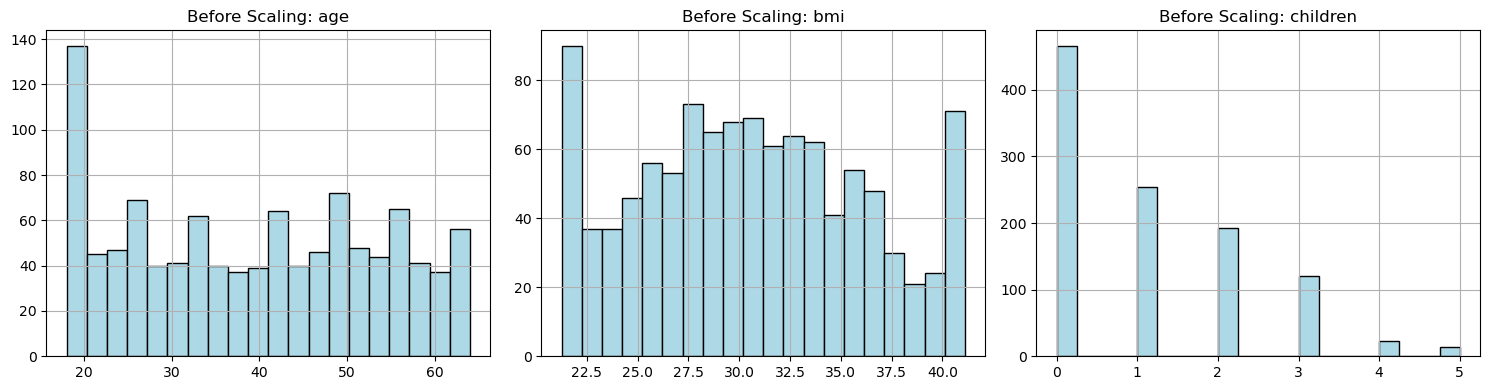

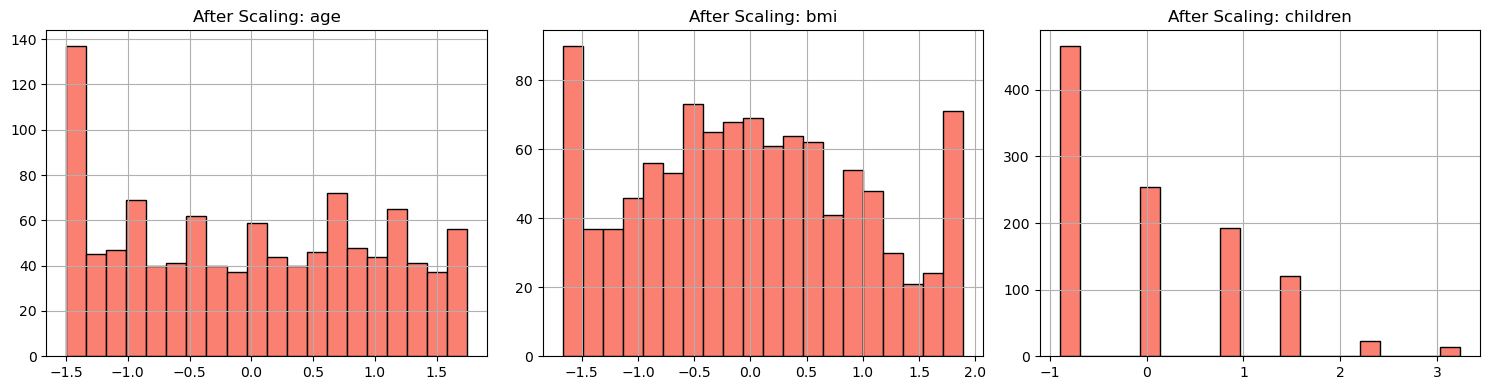

In [31]:
#  Visualize before scaling (from raw training data)
fig, axs = plt.subplots(1, len(numerical_features), figsize=(15, 4))
for i, feature in enumerate(numerical_features):
    axs[i].hist(X_train[feature], bins=20, color='lightblue', edgecolor='black')
    axs[i].set_title(f'Before Scaling: {feature}')
    axs[i].grid(True)
plt.tight_layout()
plt.show()

#  Extract scaled data from ColumnTransformer
X_train_scaled = preprocessor.named_transformers_['num'].transform(X_train[numerical_features])

# Visualize after scaling
fig, axs = plt.subplots(1, len(numerical_features), figsize=(15, 4))
for i, feature in enumerate(numerical_features):
    axs[i].hist(X_train_scaled[:, i], bins=20, color='salmon', edgecolor='black')
    axs[i].set_title(f'After Scaling: {feature}')
    axs[i].grid(True)
plt.tight_layout()
plt.show()


### Feature Scaling: Before vs After

To ensure consistent scaling during modeling, we visualized the `age`, `bmi`, and `children` features **before and after applying StandardScaler** on the training set.

- **Before scaling**: Each feature retains its original range and distribution.
- **After scaling**: Features are transformed to have zero mean and unit variance.
- This standardization is essential for models that rely on gradient descent or distance metrics.

The plots confirm that our scaling pipeline was correctly applied 